In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_excel("./data/Online Retail.xlsx")
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [4]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

In [5]:
def segment_customer(df):
    if df['RFM_Score'] >= 12:
        return 'Champions'
    elif df['RFM_Score'] >= 9:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 6:
        return 'Potential Loyalist'
    elif df['RFM_Score'] >= 3:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

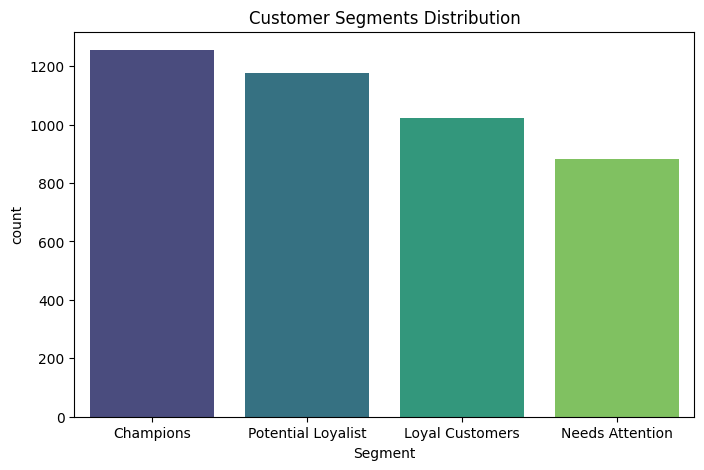

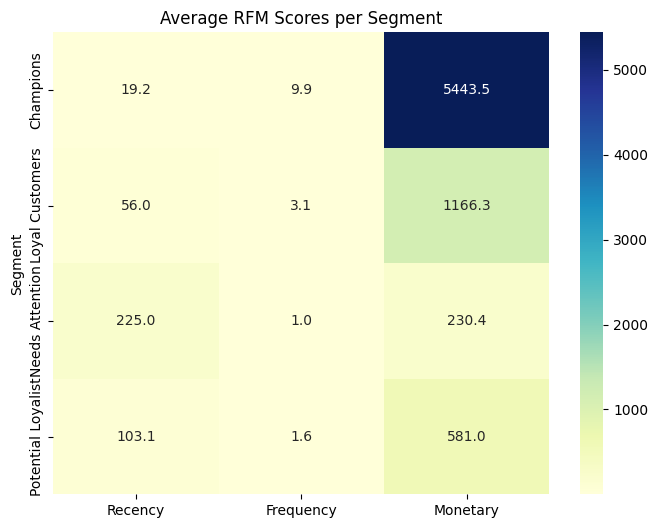

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments Distribution")
plt.show()

rfm_heatmap = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM Scores per Segment")
plt.show()